### Return Attribution

이 절에서는 Machine Learning 알고리즘을 학습시키고자 이 표본에 가중값을 두는 기법을 소개한다. 고도로 중첩되는 결과는 비중첩 결과에 비해 불균형한 가중값을 가지게 된다. 이와 동시에 큰 절대 수익률에 연계된 label들은 무시할 정도로 작은 절대 수익률을 가진 label보다 더 중요하다. 간단히 말해서 고유도와 절대 수익률을 함께 고려하는 함수를 사용해 관측값에 가중값을 부여해야 한다

label이 수익률 부호의 함수일 때 표본 가중값은 이벤트의 생애주기 $[t_{i,0}, t_{i,1}]$ 동안의 기여 수익률의 합에 의해 정의할 수 있다.

$$\tilde{w_i} = \begin{vmatrix} \sum_{t = t_{i,0}}^{t_{i,1}} \frac{r_{t-1}, t}{c_{t}}\end{vmatrix}$$

$$w_i = \tilde{w_i} I \left( \sum_{j=1}^I \tilde{w_j}\right)$$

그러므로 $\sum_{i=1}^I w_i = I$가 된다. 라이브러리는 일반적으로 알고리즘적 매개변수의 default 가중값이 1이라고 가정하므로 이 가중값의 크기를 조정해 그 합이 $I$가 되도록 했다.

이 방법의 논리는 관측값의 가중치를 관측값에 고유하게 영향을 미칠 수 있는 절대 로그 수익률의 함수로 나타내고 싶다는 것이다. 그러나 이 방법에 '중립적'인 경우가 존재하면 작동하지 않는다. 이 경우에는 더 낮은 수익률에 낮은 가중값이 아니라 더 높은 가중값이 부여돼야 한다. 결국 '중립적'인 경우는 불필요한데, 낮은 신뢰도로 '-1'이나 1'로 예측하는 것을 의미하기 때문이다. 아래의 코드는 이 방법을 구현하고 있다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from FinancialMachineLearning.labeling.labeling import *
from FinancialMachineLearning.features.volatility import daily_volatility
from FinancialMachineLearning.sample_weights.concurrency import *
from FinancialMachineLearning.utils.multiprocess import *

start_date = '2000-01-01'
end_date = '2024-04-10'
ticker = 'AAPL'
data = yf.download(
    ticker, 
    start = start_date, 
    end = end_date
)

[*********************100%%**********************]  1 of 1 completed


In [2]:
vertical_barrier = add_vertical_barrier(
    data.index, 
    data['Close'], 
    num_days = 7 # expariation limit
)
vertical_barrier.head()

Date
2000-01-03   2000-01-10
2000-01-04   2000-01-11
2000-01-05   2000-01-12
2000-01-06   2000-01-13
2000-01-07   2000-01-14
Name: Date, dtype: datetime64[ns]

In [3]:
volatility = daily_volatility(
    data['Close'], 
    lookback = 60 # moving average span
)

In [4]:
triple_barrier_events = get_events(
    close = data['Close'],
    t_events = data.index[2:],
    pt_sl = [2, 1], # profit taking 2, stopping loss 1
    target = volatility, # dynamic threshold
    min_ret = 0.01, # minimum position return
    num_threads = 1, # number of multi-thread 
    vertical_barrier_times = vertical_barrier, # add vertical barrier
    side_prediction = None # betting side prediction (primary model)
)
triple_barrier_events.head()

,t1,trgt,pt,sl
Date,,,,
2000-01-07,2000-01-11,0.016797,2,1
2000-01-10,2000-01-12,0.026415,2,1
2000-01-11,2000-01-12,0.024043,2,1
2000-01-12,2000-01-13,0.031168,2,1
2000-01-13,2000-01-19,0.050703,2,1


In [5]:
labels = meta_labeling(
    triple_barrier_events, 
    data['Close']
)

In [6]:
labels.head()

,ret,trgt,bin
Date,,,
2000-01-07,-0.067839,0.016797,-1
2000-01-10,-0.108056,0.026415,-1
2000-01-11,-0.059973,0.024043,-1
2000-01-12,0.109677,0.031168,1
2000-01-13,0.101422,0.050703,0


In [7]:
triple_barrier_events['side'] = labels['bin']
triple_barrier_events.head()

,t1,trgt,pt,sl,side
Date,,,,,
2000-01-07,2000-01-11,0.016797,2,1,-1.0
2000-01-10,2000-01-12,0.026415,2,1,-1.0
2000-01-11,2000-01-12,0.024043,2,1,-1.0
2000-01-12,2000-01-13,0.031168,2,1,1.0
2000-01-13,2000-01-19,0.050703,2,1,0.0


In [8]:
num_threads = 1
num_conc_events = mp_pandas_obj(
    concurrent_events, 
    ('molecule', triple_barrier_events.index), 
    num_threads, 
    close_series_index = data['Close'].index, 
    label_endtime = triple_barrier_events['t1']
)

In [9]:
num_conc_events = num_conc_events.reindex(data['Close'].index).fillna(0)

In [10]:
triple_barrier_events[:-5]

,t1,trgt,pt,sl,side
Date,,,,,
2000-01-07,2000-01-11,0.016797,2,1,-1.0
2000-01-10,2000-01-12,0.026415,2,1,-1.0
2000-01-11,2000-01-12,0.024043,2,1,-1.0
2000-01-12,2000-01-13,0.031168,2,1,1.0
2000-01-13,2000-01-19,0.050703,2,1,0.0
...,...,...,...,...,...
2024-03-26,2024-04-02,0.018161,2,1,0.0
2024-03-27,2024-04-03,0.018151,2,1,-1.0
2024-03-28,2024-04-04,0.018013,2,1,0.0


In [11]:
from FinancialMachineLearning.sample_weights.attribution import *

return_weights = weights_by_return(triple_barrier_events[:-5], data['Close'][:-5], num_threads = 1)

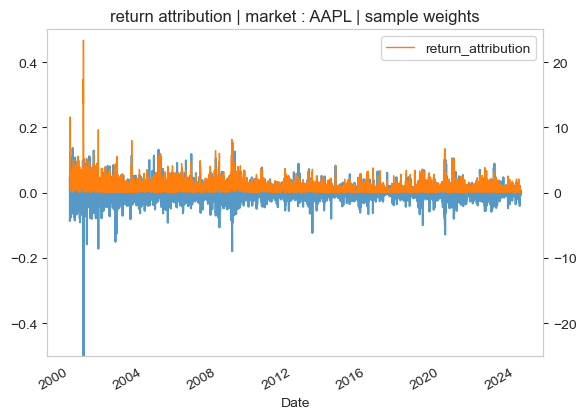

In [12]:
data['Close'].pct_change().plot(alpha = 0.75)
plt.ylim([-0.5, 0.5])
plt.grid(False)

return_weights.plot(secondary_y=True, lw = 1)
plt.ylim([-25, 25])
plt.legend(['return_attribution'])
plt.grid(False)

plt.title('return attribution | market : AAPL | sample weights')
plt.show()